In [28]:
# This cell changes display settings for the notebook.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
import train_models
from PIL import Image, ImageFilter
from misc_functions import (
    get_example_params, convert_to_grayscale, save_gradient_images, preprocess_image
    )
from vanilla_backprop import VanillaBackprop 
from gradcam import GradCam


In [30]:




def grad_cam(dataset,dp,example_index):
    pretrained_model,classes,trainloader,testloader,trainset,testset = train_models.get_trained_model(dataset,dp)
    
    for param in pretrained_model.parameters():
        param.requires_grad = False 

    f, axarr = plt.subplots(1,2) 
    f.set_figheight(7)
    f.set_figwidth(7)

    print('model loaded, forwarding examples')

    dataiter = iter(testloader)
    images, labels = dataiter.next()

    mean=[0.5, 0.5, 0.5]
    std=[0.5, 0.5, 0.5]
    denormalized_image = images[example_index] * torch.tensor(std).view(3, 1, 1)
    denormalized_image = denormalized_image + torch.tensor(mean).view(3, 1, 1)
    
    original_image = transforms.ToPILImage(mode='RGB')(denormalized_image)
    prep_img = preprocess_image(original_image,True)
    grad_cam = GradCam(pretrained_model, target_layer=11)
    
    yhat = pretrained_model.forward(images.cuda())
    target_class = np.argmax(yhat[example_index].data.cpu().numpy())
    
    cam = grad_cam.generate_cam(prep_img, target_class)
    print(f'\nPredicted Class: {classes[target_class]}')

    axarr[0].imshow(original_image)
    axarr[0].title.set_text(f'Original Image - ')
    axarr[1].imshow(cam)
    if dp:
        axarr[1].title.set_text(f'Gradient CAM - DP')
    else:
        axarr[1].title.set_text(f'Gradient CAM - no DP')
    
    plt.show()    


# Visualization for class saliency map using vanilla backprop
def vanilla_backprop_saliency(dataset,dp,example_index):
    model,classes,trainloader,testloader,trainset,testset = train_models.get_trained_model(dataset,dp) 
    
    f, axarr = plt.subplots(1,2) 
    f.set_figheight(7)
    f.set_figwidth(7)
    VBP = VanillaBackprop(model)

    print('model loaded, forwarding examples')
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    mean=[0.5, 0.5, 0.5]
    std=[0.5, 0.5, 0.5]
    denormalized_image = images[example_index] * torch.tensor(std).view(3, 1, 1)
    denormalized_image = denormalized_image + torch.tensor(mean).view(3, 1, 1)
    original_image = transforms.ToPILImage(mode='RGB')(denormalized_image)
    prep_img = preprocess_image(original_image,True)
    vanilla_grads = VBP.generate_gradients(prep_img)
    grayscale_vanilla_grads = convert_to_grayscale(vanilla_grads)
    
    yhat = model.forward(images.cuda())
    target_class = np.argmax(yhat[example_index].data.cpu().numpy())
    print(f'\nPredicted Class: {classes[target_class]}')

    axarr[0].imshow(original_image)
    axarr[0].title.set_text(f'Original Image - ')
    axarr[1].imshow(grayscale_vanilla_grads.squeeze(0))
    if dp:
        axarr[1].title.set_text(f'Gradient CAM - DP')
    else:
        axarr[1].title.set_text(f'Gradient CAM - no DP') 
    plt.show()    

def test_model_accuracy(dataset,dp):
    model,classes,trainloader,testloader,trainset,testset = train_models.get_trained_model(dataset,dp)
    print('model loaded, testing test set')

    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images.cuda())
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels.cuda()).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
                
                correct+=c[i].item()
                total+=1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (classes[i],100 * class_correct[i] / class_total[i]))
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
# Visualization for gradient class activation map using vanilla backprop





# What does a model learn?
Neural Networks are machine learning models that are designed to optimize the loss produced by the model, with respect to the weights that it uses while propagating inputs through the different layers of the network. More intuitively, image classificaiton models use pixel data as inputs, in order to recognize patterns in pixel data, and more accuractly classify target classes presented in training data. 

For example, using a saliency map, we can see from the output of the model some insight about which pixels the model has intuitively "learned" about during training. We can see from the following examples that the models both get a pretty good sense for the digits they are looking to classify during training. The pixels with higher intensities are ones that the model believes to be part of the target class.

The following two examples demonstrate the differences in the saliency maps produced for a vanilla AlexNet, and a differentially private AlexNet. Both models were trained using the same training flow and parameters, as well as networks structure. The only difference being in the differentially private optimizaiton techniques applied to the second model.

First show the vanilla model...

using dataset:      mnist
Model valid:        True
Model trained DP:   False
10
model loaded, testing test set
Accuracy of  zero : 91 %
Accuracy of   one : 98 %
Accuracy of   two : 97 %
Accuracy of three : 95 %
Accuracy of  four : 91 %
Accuracy of  five : 94 %
Accuracy of   six : 95 %
Accuracy of seven : 98 %
Accuracy of eight : 99 %
Accuracy of  nine : 96 %
Accuracy of the network on the 10000 test images: 96 %
using dataset:      mnist
Model valid:        True
Model trained DP:   False
10
model loaded, forwarding examples

Predicted Class: zero


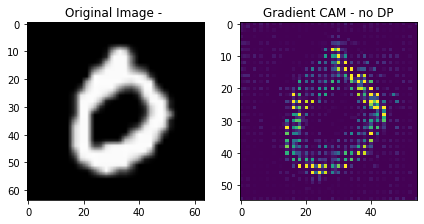

In [35]:
dataset        = 'mnist' 
dp             = False
example_index  = 3       # (Not looking for class 3, rather index 3 from the dataloader used to present these examples)

test_model_accuracy(dataset,dp)
vanilla_backprop_saliency(dataset,dp,example_index)

Then the diffierentially private model...

using dataset:      mnist
Model valid:        True
Model trained DP:   True
10
model loaded, testing test set
Accuracy of  zero : 87 %
Accuracy of   one : 91 %
Accuracy of   two : 80 %
Accuracy of three : 77 %
Accuracy of  four : 78 %
Accuracy of  five : 65 %
Accuracy of   six : 83 %
Accuracy of seven : 80 %
Accuracy of eight : 63 %
Accuracy of  nine : 74 %
Accuracy of the network on the 10000 test images: 78 %
using dataset:      mnist
Model valid:        True
Model trained DP:   True
10
model loaded, forwarding examples

Predicted Class: zero


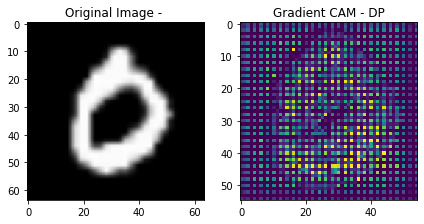

In [36]:

dataset        = 'mnist'  
dp             = True
# example_index  = 7

test_model_accuracy(dataset,dp)
vanilla_backprop_saliency(dataset,dp,example_index)

We can see some interesting differences between what the two models output for the same input. We can certainly still distinguish our class from this saliency map, but there is a lot more noise in the saliency map, perhaps suggesting that applying noise to the process of gradient optimzation can impact our overall privacy measure for the model, which are quantified by `epsilon` and `delta`. One important observation to make is the difference in accuracy between the models. The differentially private model demonstrates a lower level of accuracy for classifcation tasks, however this coincides with the slower rate of loss convergence it demonstrates

We see in the following examples, visuzalitions of hidden layers, the outline the pixels that provide the highest level of neuron activity, or the classification target. As such, we can still see elements of the original image outlined by the activation map.

using dataset:      mnist
Model valid:        True
Model trained DP:   False
10
model loaded, forwarding examples

Predicted Class: zero


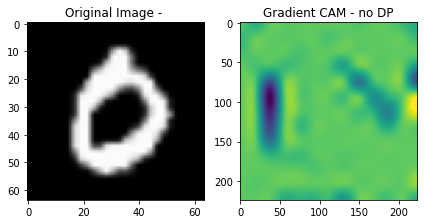

In [39]:
dataset        = 'mnist'  
dp             = False
# example_index  = 7

grad_cam(dataset,dp,example_index) 

This final cell demonstrates the same class activation mapping technique, but with a differentially private model. Again we notice more obfuscation in the image, and it seems as though there is a lot of noise that seems to be signaling class activation. This suggests that the differentially private model is still learning, but encountering more noise in the training data.

using dataset:      mnist
Model valid:        True
Model trained DP:   True
10
model loaded, forwarding examples

Predicted Class: zero


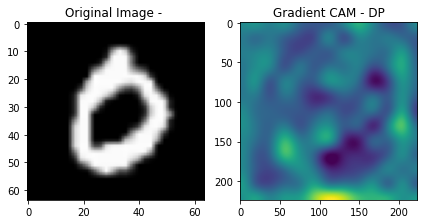

In [40]:
dataset        = 'mnist'  
dp             = True
# example_index  = 7

grad_cam(dataset,dp,example_index) 